<h1>Import frameworks</h1>

In [19]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torchvision import datasets
from torch.utils.data import DataLoader


#gpu_device = torch.device("cpu")
#if torch.backends.mps.is_available():
#    gpu_device = torch.device("mps")
#else:
#    print ("MPS device not found.")

<h1>Import datasets</h1>

In [41]:
batch_size = 32

transform = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Normalize((0.5,), (0.5,))  
])

train_dataset = datasets.MNIST(root='Assignment6/', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='Assignment6/', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print("train dataset: ", len(train_dataset))
print("test dataset: ", len(test_dataset))



train dataset:  60000
test dataset:  10000


<h1>Plot images</h1>

Image shape: torch.Size([64, 1, 28, 28])
Label shape: torch.Size([64])


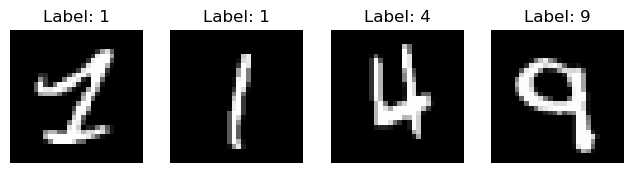

<Figure size 640x480 with 0 Axes>

In [33]:

for images, labels in train_loader:
    print("Image shape:", images.size())
    print("Label shape:", labels.size()) 

    plt.figure(figsize=(10, 10))
    for i in range(4):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray') 
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.show()
    plt.savefig('mnist_images.png', bbox_inches='tight')
    break  


<h1>Neural Network</h1>

In [46]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(NeuralNet, self).__init__()
        layer_sizes = [input_size] + hidden_sizes + [output_size]
        
        layers = []
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            if i < len(layer_sizes) - 2:  # Add ReLU except for the last layer
                layers.append(nn.ReLU())


        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.reshape(-1, 28*28)
        return self.model(x)

<h1>Training</h1>

In [51]:
def train(model, criterion, optimizer, train_loader, test_loader, num_epochs, name):
    train_losses = []  
    test_losses = []

    for epoch in range(num_epochs):
        model.train()  
        running_loss = 0.0

        for images, labels in train_loader:
            #images, labels = inputs.to(gpu_device), labels.to(gpu_device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        model.eval()
        test_loss = 0.0
        for images, labels in test_loader:
            #images, labels = inputs.to(gpu_device), labels.to(gpu_device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
        test_loss /= len(test_loader)
        test_losses.append(test_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}, Test Loss: {test_loss:.4f}")


    fig, ax = plt.subplots(figsize=(8, 6), layout='constrained')
    ax.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    ax.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title('Training and Test Losses')
    ax.legend()
    plt.show()
    fig.savefig(name  +  ".pdf", bbox_inches='tight')


<h1>Single hidden layer</h1>

Epoch [1/10], Training Loss: 0.3386, Test Loss: 0.1698
Epoch [2/10], Training Loss: 0.1547, Test Loss: 0.1262
Epoch [3/10], Training Loss: 0.1172, Test Loss: 0.1279
Epoch [4/10], Training Loss: 0.0991, Test Loss: 0.1070
Epoch [5/10], Training Loss: 0.0839, Test Loss: 0.1011
Epoch [6/10], Training Loss: 0.0741, Test Loss: 0.1152
Epoch [7/10], Training Loss: 0.0670, Test Loss: 0.0918
Epoch [8/10], Training Loss: 0.0599, Test Loss: 0.0836
Epoch [9/10], Training Loss: 0.0532, Test Loss: 0.0952
Epoch [10/10], Training Loss: 0.0470, Test Loss: 0.1334


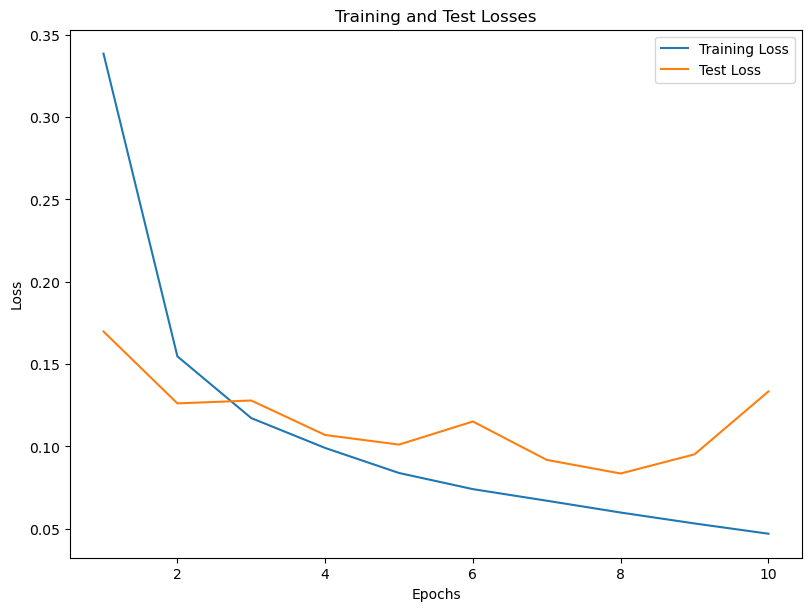

In [52]:
input_size = 28 * 28 
hidden_sizes = [128] # Is 128 the best choice?
output_size = 10  

model = NeuralNet(input_size, hidden_sizes, output_size)
#model = model.to(gpu_device)

learning_rate = 0.1
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
num_epochs = 10
criterion = nn.CrossEntropyLoss()

train(model, criterion, optimizer, train_loader, test_loader, num_epochs, "single_hidden_layer")

<h1>Two hidden layer</h1>

In [53]:
input_size = 28 * 28   
hidden_sizes = [500, 300]  
output_size = 10  
weight_decay = 0.01
model = NeuralNet(input_size, hidden_sizes, output_size)

learning_rate = 0.1
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
num_epochs = 40
criterion = nn.CrossEntropyLoss()

train(model, criterion, optimizer, train_loader, test_loader, num_epochs, "two_hidden_layer")



Epoch [1/40], Training Loss: 0.4406, Test Loss: 0.3193
Epoch [2/40], Training Loss: 0.2893, Test Loss: 0.3053


KeyboardInterrupt: 

<h1>Convolutional neural network</h1>

In [54]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

<h1>Train convolutional neural network</h1>

In [55]:

model = CNN()

weight_decay = 0.01
learning_rate = 0.1
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
num_epochs = 40
criterion = nn.CrossEntropyLoss()

train(model, criterion, optimizer, train_loader, test_loader, num_epochs, "cnn")

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [32, 784]